# Add environmental data
This notebook is the code to add environmental data to the output of pypam
For more information about this process please contact clea.parcerisas@vliz.be or check the documentation of both packages
https://lifewatch-pypam.readthedocs.io/en/latest/
https://github.com/lifewatch/bpnsdata

In [1]:
import pathlib
import os

import geopandas
import pandas as pd
import xarray
from tqdm import tqdm

import bpnsdata

import erddapy
print(erddapy.__version__)

C:\Users\cleap\Envs\wadden_soundscape\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


2.0.2


In [2]:
raw_data_path = pathlib.Path('./data/raw_data')
processed_data_path = pathlib.Path('./data/processed')
metadata_path = raw_data_path.joinpath('data_summary_mda.csv')
metadata = pd.read_csv(metadata_path, index_col=False)

if not processed_data_path.exists():
    os.mkdir(processed_data_path)

env_vars = [
		"shipping",
		"time",
		"bathymetry"
    ]


# Change this to the columns you add in the csv!
# YOU NEED TO KEEP deployment_name
env_vars_from_csv = ['sediment_type', 'tide', 'deployment_name']

In [3]:
metadata

,deployment_name,campaign,instrument_name,instrument_sensitivity,instrument_amp,instrument_Vpp,deployment_path,timezone,include_dirs,calibration,latitude,longitude,end_to_end_calibration,sediment_type,tide,new_var
0,NLOyster1,1,SoundTrap,-170.0,0,2,0_NLOyster1.nc,UTC,0,-1,53.06843,4.88076,NaN,reef,low,a
1,NLOyster2High,1,SoundTrap,-170.0,0,2,1_NLOyster2High.nc,UTC,0,-1,53.06843,4.88076,NaN,reef,high,a
2,NLOyster2Low,1,SoundTrap,-170.0,0,2,2_NLOyster2Low.nc,UTC,0,-1,53.06843,4.88076,NaN,reef,low,a
3,NLSand1,2,SoundTrap,-170.0,0,2,3_NLSand1.nc,UTC,0,-1,53.06843,5.20231,NaN,sand,low,a
4,NLSand2,2,SoundTrap,-160.0,0,2,4_NLSand2.nc,UTC,0,-1,53.06843,5.20231,NaN,sand,low,a
5,MusselbedHigh,3,uaural,-164.0,12,2,5_MusselbedHigh.nc,UTC,0,-1,53.06843,5.20231,NaN,mussel,high,a
6,MusselbedLow,3,uaural,-164.0,12,2,6_MusselbedLow.nc,UTC,0,-1,53.06843,5.20231,NaN,mussel,low,a
7,MudHigh,4,uaural,-164.0,12,2,7_MudHigh.nc,UTC,0,-1,53.06843,5.20231,NaN,mud,high,a
8,MudLow,4,uaural,-164.0,12,2,8_MudLow.nc,UTC,0,-1,53.06843,5.20231,NaN,mud,low,a
9,GeoReefHigh,5,uaural,-164.0,12,2,9_GeoReefHigh.nc,UTC,0,-1,53.06843,5.20231,NaN,georeef,high,a


In [4]:
# Define the seadatamanager
manager = bpnsdata.SeaDataManager(env_vars)
id_name = 'id'
datetime_name = 'datetime'
for i, row in tqdm(metadata.iterrows(), total=len(metadata)):
    deployment_path = raw_data_path.joinpath('deployments/deployments', row['deployment_path'])
    env_path = processed_data_path.joinpath(row['deployment_path'].replace('.nc', '_env.nc'))
    print(env_path)

    # Read the dataset
    ds_deployment = xarray.open_dataset(deployment_path, engine='netcdf4')
    # Get the time information from the dataset to get a pandas df
    datetime_index = ds_deployment[datetime_name].to_index()
    df = pd.DataFrame({"datetime": datetime_index.values, 'id': ds_deployment[id_name]})
    df = df.drop_duplicates("datetime")
    print(metadata.iloc[i]['deployment_name'], len(datetime_index), len(df))
    df.datetime = df.datetime.dt.tz_localize('UTC')

    df['latitude'] = row['latitude']
    df['longitude'] = row['longitude']

    # Generate the location information
    geodf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(x=df['longitude'], y=df['latitude']), crs='EPSG:4326')
    geodf_env = manager(geodf, datetime_column='datetime')

    for env_var in env_vars_from_csv:
        geodf_env[env_var] = row[env_var]

    # Remove the UTC (xarray does not support it?)
    dt = geodf_env.datetime.dt.tz_localize(None)
    lat = geodf_env['geometry'].y
    lon = geodf_env['geometry'].x
    df_env = geodf_env.drop(columns=['geometry'])
    env_ds = df_env.to_xarray()
    env_ds = env_ds.assign_coords(coords={'lat': (id_name, lat), 'lon': (id_name, lon), 'datetime': (id_name, dt), id_name : ('index', df.id.values)})
    env_ds = env_ds.swap_dims({'index': id_name})

    new_ds = ds_deployment.merge(env_ds)
    new_ds['season'] = new_ds[datetime_name].dt.isocalendar().week

    encoding = {'file_path': {'dtype': 'unicode'},
                'start_sample': {'dtype': int, '_FillValue': -1},
                'end_sample': {'dtype': int, '_FillValue': -1},
                'datetime': {'dtype': float, '_FillValue': -1},
                'deployment_name': {'dtype': str,}}
    new_ds.to_netcdf(env_path,  encoding=encoding)
    # print(new_ds)
    ds_deployment.close()

  0%|          | 0/15 [00:00<?, ?it/s]

data\processed\0_NLOyster1_env.nc
NLOyster1 607 607


  7%|▋         | 1/15 [00:11<02:34, 11.07s/it]

data\processed\1_NLOyster2High_env.nc
NLOyster2High 181 180


 13%|█▎        | 2/15 [00:14<01:26,  6.64s/it]

data\processed\2_NLOyster2Low_env.nc
NLOyster2Low 424 424


 20%|██        | 3/15 [00:23<01:30,  7.50s/it]

data\processed\3_NLSand1_env.nc
NLSand1 605 605


 27%|██▋       | 4/15 [00:34<01:39,  9.02s/it]

data\processed\4_NLSand2_env.nc
NLSand2 603 603


 33%|███▎      | 5/15 [00:45<01:35,  9.59s/it]

data\processed\5_MusselbedHigh_env.nc
MusselbedHigh 366 366


 40%|████      | 6/15 [00:51<01:16,  8.51s/it]

data\processed\6_MusselbedLow_env.nc
MusselbedLow 366 366


 47%|████▋     | 7/15 [00:57<01:02,  7.76s/it]

data\processed\7_MudHigh_env.nc
MudHigh 427 427


 53%|█████▎    | 8/15 [01:05<00:54,  7.73s/it]

data\processed\8_MudLow_env.nc
MudLow 366 366


 60%|██████    | 9/15 [01:12<00:44,  7.39s/it]

data\processed\9_GeoReefHigh_env.nc
GeoReefHigh 549 549


 67%|██████▋   | 10/15 [01:21<00:39,  7.94s/it]

data\processed\10_GeoReefLow_env.nc
GeoReefLow 427 427


 73%|███████▎  | 11/15 [01:28<00:31,  7.84s/it]

data\processed\11_MusselShellsHigh_env.nc
MusselShellsHigh 549 549


 80%|████████  | 12/15 [01:38<00:25,  8.48s/it]

data\processed\12_MusselShellsLow_env.nc
MusselShellsLow 549 549


 87%|████████▋ | 13/15 [01:48<00:17,  8.83s/it]

data\processed\13_CoarseSandHigh_env.nc
CoarseSandHigh 549 549


 93%|█████████▎| 14/15 [01:58<00:09,  9.12s/it]

data\processed\14_CoarseSandLow_env.nc
CoarseSandLow 549 549


100%|██████████| 15/15 [02:07<00:00,  8.51s/it]


In [5]:
geodf_env

,datetime,id,latitude,longitude,geometry,route_density,moon_phase,day_moment,bathymetry,sediment_type,tide,deployment_name
0,2022-06-16 11:04:36+00:00,0,53.06843,5.20231,POINT (5.20231 53.06843),8.0,3.630688,Day,-1.555,coarsesand,low,CoarseSandLow
1,2022-06-16 11:04:46+00:00,1,53.06843,5.20231,POINT (5.20231 53.06843),8.0,3.630717,Day,-1.555,coarsesand,low,CoarseSandLow
2,2022-06-16 11:04:56+00:00,2,53.06843,5.20231,POINT (5.20231 53.06843),8.0,3.630745,Day,-1.555,coarsesand,low,CoarseSandLow
3,2022-06-16 11:05:06+00:00,3,53.06843,5.20231,POINT (5.20231 53.06843),8.0,3.630774,Day,-1.555,coarsesand,low,CoarseSandLow
4,2022-06-16 11:05:16+00:00,4,53.06843,5.20231,POINT (5.20231 53.06843),8.0,3.630802,Day,-1.555,coarsesand,low,CoarseSandLow
...,...,...,...,...,...,...,...,...,...,...,...,...
544,2022-06-15 22:40:19+00:00,544,53.06843,5.20231,POINT (5.20231 53.06843),8.0,3.502747,Astronomical twilight,-1.555,coarsesand,low,CoarseSandLow
545,2022-06-15 22:40:29+00:00,545,53.06843,5.20231,POINT (5.20231 53.06843),8.0,3.502776,Astronomical twilight,-1.555,coarsesand,low,CoarseSandLow
546,2022-06-15 22:40:39+00:00,546,53.06843,5.20231,POINT (5.20231 53.06843),8.0,3.502804,Astronomical twilight,-1.555,coarsesand,low,CoarseSandLow
547,2022-06-15 22:40:49+00:00,547,53.06843,5.20231,POINT (5.20231 53.06843),8.0,3.502833,Astronomical twilight,-1.555,coarsesand,low,CoarseSandLow


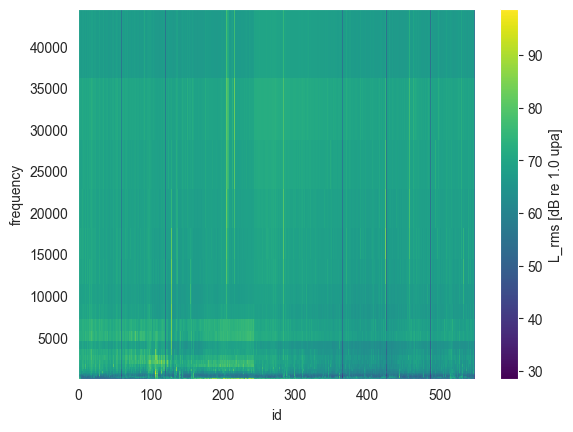

In [6]:
new_ds['oct3'].plot(x='id', y='frequency')

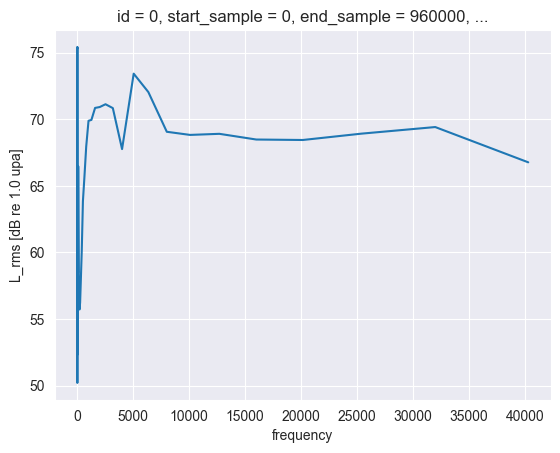

In [7]:
new_ds.sel(id=0)['oct3'].plot()